# Excess properties for a HB-inert mixture

In this document we compare the excess properties calculated by our `SAC` implementation for a hydrogen bonding (HB)-inert system. The pair interaction energies are the same as given by [Egner et al. (1997)](https://doi.org/10.1002/bbpc.19971010208).

We start by importing the necessary packages.

In [20]:
import math, os, sys
import matplotlib.pyplot as plt
import pandas as pd

parent_directory = os.path.dirname(os.path.abspath('.'))
sys.path.append(parent_directory)

from pysac import SAC, RGAS, RGAS_SI, DEFAULT_Q_EFF

## Compound definitions

Ther original article considered a simple-cubic lattice (z = 6). Then, in order to compare the results with the cubic lattice system we need to set the areas accordingly.


In [21]:
Q_eff = DEFAULT_Q_EFF;
Q_1   = [4*Q_eff, Q_eff, Q_eff]
Q_2   = [6*Q_eff]

# The mixture area
Q = [Q_1, Q_2]
nu = 6

## Interaction energies

There is one hydrogen-bonding (HB) compound. For this compound there is an inert area and two hydrogen bonding sites (donor and acceptor). The donor-acceptor pair has a high attractive (negative) interaction energy. For donor-donor or acceptor-acceptor pairs, the interaction energy is positive. All other contacts with inert surface segments have zero interaction energy.

In [22]:
T0 = 300

class EgnerHBInert(SAC):
    def __init__(self):
        super().__init__(Q_eff=Q_eff, tol=1e-10)

    # Interaction energies according to Table 3 of the original article
    def calc_u(self, T, i, j, m, n):
        if i == 1 or j == 1:
            # no interaction with the inert compound
            return 0
        if m == 0 or n == 0:
            # no interaction with the neutral/inert part of the molecules
            return 0
        if (m == n):
            # e11 and e22, repulsive interaction
            return 340 * RGAS
        
        # e12 and e21, very strong negative (attractive, hydrogen bond)
        return -1250 * RGAS

# Create an instance of our SAC class
sac = EgnerHBInert()

# Set a temperature, we use the reference `T0` so we get the same
# results as in the original work.
T = T0
sac.set_compounds(Q)
sac.set_temperature(T)

## Excess properties

Here we calculate the excess properties on multiple compositions and compare our results with Monte-Carlo simulations from the original work.

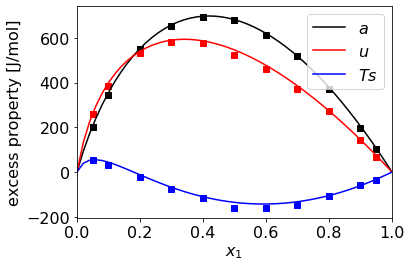

In [23]:
N = 51
ue = []
ae = []
tse = []

# Monte-Carlo data from Fig. 6 (image recognition) of the original work
x1_exp = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
ge_exp = [201.1, 344.9, 548.0, 652.9, 691.4, 677.4, 614.4, 516.5, 372.7, 197.8, 103.3]
he_exp = [257.5, 383.5, 533.9, 582.9, 575.8, 523.6, 460.6, 372.7, 271.2, 145.2, 68.1]
tse_exp = [54.38, 29.55, -22.70, -75.32, -117.20, -162.79, -159.45, -145.37, -106.83, -57.91, -36.78]

x1 = []

for l in range(N):
    x1_ = l/(N-1)
    x1.append(x1_)

    x = [x1_, 1-x1_]
    
    sac.set_composition(x)
    sac.calc_ln_gamma()

    ae_ = sac.get_helmholtz()
    ue_ = sac.get_energy()
    se_ = sac.get_entropy()

    alpha = sac.get_nonrandom()

    # subtract the pure compound energies to get the excess
    for i in range(len(x)):
        ue_ -= x[i]*sac.get_energy_pure(i)
        ae_ -= x[i]*sac.get_helmholtz_pure(i)
        se_ -= x[i]*sac.get_entropy_pure(i)
    
    ae.append(ae_ * RGAS_SI * T)
    ue.append(ue_ * RGAS_SI * T)
    tse.append(se_ * RGAS_SI * T)

plt.plot(x1_exp, ge_exp, 'ks')
plt.plot(x1_exp, he_exp, 'rs')
plt.plot(x1_exp, tse_exp, 'bs')
plt.plot(x1, ae, 'k-', label=r'$a$')
plt.plot(x1, ue, 'r-', label=r'$u$')
plt.plot(x1, tse, 'b-', label=r'$Ts$')

plt.legend(loc='upper right')
plt.xlabel(r'$x_1$')
plt.ylabel(r'excess property [J/mol]')
plt.xlim([0, 1])
#plt.ylim([-0.6, 0.6])

plt.rcParams.update({'font.size': 16})
plt.tight_layout()
plt.plot()
plt.savefig('pdf/egner_hb_inert.pdf')

### Small positive excess entropy for diluted compound 1

Preferential contacts generate negative contributions to the residual entropy.

For the present case, the HB compound has great order (nonrandomness) when pure. Compound 2 has no preferential interactions when pure, so zero residual entropy.

In [24]:
x = [0.05, 0.95]
sac.set_composition(x)
sac.calc_ln_gamma()

print("0.05 mols of pure compound 1, T*s [J]: ", x[0]*sac.get_entropy_pure(0) * RGAS_SI*T)
print("0.95 mols of pure compound 2, T*s [J]: ", x[1]*sac.get_entropy_pure(1) * RGAS_SI*T)
print("5% compound 1 mixture, T*s [J/mol]: ", sac.get_entropy() * RGAS_SI*T)
print("5% compound 1 mixture, excess T*s [J/mol]: ", (sac.get_entropy()-x[0]*sac.get_entropy_pure(0)-x[1]*sac.get_entropy_pure(1)) * RGAS_SI*T)

0.05 mols of pure compound 1, T*s [J]:  -155.9552318020756
0.95 mols of pure compound 2, T*s [J]:  0.0
5% compound 1 mixture, T*s [J/mol]:  -100.94217861517205
5% compound 1 mixture, excess T*s [J/mol]:  55.01305318690352


The pair contact residual entropy contributions for a HB pure compound are more complex than for a simple polar compound. There are the HB pairs (2-3 and 3-2) which are the more likely, with the largest negative contribution. However, this preferential pair has a smaller surface area. There are many repulsive pairs, with positive residual entropy contributions. This makes the neutral/inert pair (1-1) to be contribute as the second more negative term.

In [25]:
print("Entropy terms (times T) for 0.05 mols of pure compound 1 [J]:")
i = j = 0
alpha = sac.get_nonrandom_pure(i)
theta_i = sac.theta_pure[i]
seg_gamma_i = sac.seg_gamma_pure[i]
theta_j = sac.theta_pure[j]
seg_gamma_j = sac.seg_gamma_pure[j]
psi_ij = sac.psi[i][j]
for m in range(len(theta_i)):
    for n in range(len(theta_j)):
        alpha_mn = seg_gamma_i[m] * seg_gamma_j[n] * psi_ij[m][n]
        si = -nu/2 * theta_i[m]*theta_j[n] * alpha_mn * (math.log(alpha_mn)) * RGAS_SI*T

        print(f"segments {m+1}-{n+1}: {x[0]*si}")

Entropy terms (times T) for 0.05 mols of pure compound 1 [J]:
segments 1-1: -65.90477003193477
segments 1-2: 15.118191835409878
segments 1-3: 15.118189252596402
segments 2-1: 15.118191835409878
segments 2-2: 0.918095760010282
segments 2-3: -76.17970689791036
segments 3-1: 15.118189252596402
segments 3-2: -76.17970689791036
segments 3-3: 0.9180940896570748


In a diluted mixture of compound 1, the strong negative entropy for the 1-1 pair (neutral pair) vanishes. This is because this pair has now more neutrals pairs to interact with (from compound 2). Surprisingly, this is the dominant effect in this case. The HB pair negative contribution is only slightly reduced in this mixture.

In [26]:
print("\nEntropy terms (times T) for a mixture with 0.05 mols of compound 1 [J]:")
alpha = sac.get_nonrandom()
for i in range(sac.ncomps):
    theta_i = sac.theta[i]
    seg_gamma_i = sac.seg_gamma[i]

    for j in range(sac.ncomps):
        theta_j = sac.theta[j]
        seg_gamma_j = sac.seg_gamma[j]

        psi_ij = sac.psi[i][j]

        print(f"Compounds: {i+1}-{j+1}")

        for m in range(len(theta_i)):
            for n in range(len(theta_j)):
                alpha = seg_gamma_i[m] * seg_gamma_j[n] * psi_ij[m][n]
                si = -nu/2 * theta_i[m]*theta_j[n] * alpha * (math.log(alpha)) * RGAS_SI*T

                print(f"segments {m+1}-{n+1}: {si}")


Entropy terms (times T) for a mixture with 0.05 mols of compound 1 [J]:
Compounds: 1-1
segments 1-1: -0.03848659074182976
segments 1-2: 0.4810559621008883
segments 1-3: 0.4810559570537739
segments 2-1: 0.4810559621008883
segments 2-2: 0.156386740664218
segments 2-3: -62.263299908354014
segments 3-1: 0.4810559570537739
segments 3-2: -62.263299908354014
segments 3-3: 0.15638674133221056
Compounds: 1-2
segments 1-1: -1.0968678347555083
segments 2-1: 13.71009492004571
segments 3-1: 13.710094776202954
Compounds: 2-1
segments 1-1: -1.096867834755508
segments 1-2: 13.71009492004571
segments 1-3: 13.710094776202954
Compounds: 2-2
segments 1-1: -31.260733251014248


### Negative excess entropy for an equimolar mixture

For an equimolar mixture there is even more order in mixture than in pure compounds. Producing a negative excess entropy.

In [27]:
x = [0.5, 0.5]
sac.set_composition(x)
sac.calc_ln_gamma()

print("0.5 mols of pure compound 1, T*s [J]: ", 0.5*sac.get_entropy_pure(0) * RGAS_SI*T)
print("0.5 mols of pure compound 2, T*s [J]: ", 0.5*sac.get_entropy_pure(1) * RGAS_SI*T)
print("Equimolar mixture, T*s [J/mol]: ", sac.get_entropy() * RGAS_SI*T)
print("Equimolar mixture, excess T*s [J/mol]: ", (sac.get_entropy()-x[0]*sac.get_entropy_pure(0)-x[1]*sac.get_entropy_pure(1)) * RGAS_SI*T)

0.5 mols of pure compound 1, T*s [J]:  -1559.5523180207556
0.5 mols of pure compound 2, T*s [J]:  0.0
Equimolar mixture, T*s [J/mol]:  -1694.9715264791241
Equimolar mixture, excess T*s [J/mol]:  -135.41920845836853


In [28]:
print("Entropy terms (times T) for 0.5 mols of pure compound 1 [J]:")
i = j = 0
alpha = sac.get_nonrandom_pure(i)
theta_i = sac.theta_pure[i]
seg_gamma_i = sac.seg_gamma_pure[i]
theta_j = sac.theta_pure[j]
seg_gamma_j = sac.seg_gamma_pure[j]
psi_ij = sac.psi[i][j]
for m in range(len(theta_i)):
    for n in range(len(theta_j)):
        alpha_mn = seg_gamma_i[m] * seg_gamma_j[n] * psi_ij[m][n]
        si = -nu/2 * theta_i[m]*theta_j[n] * alpha_mn * (math.log(alpha_mn)) * RGAS_SI*T

        print(f"segments {m+1}-{n+1}: {x[0]*si}")

Entropy terms (times T) for 0.5 mols of pure compound 1 [J]:
segments 1-1: -659.0477003193478
segments 1-2: 151.18191835409877
segments 1-3: 151.181892525964
segments 2-1: 151.18191835409877
segments 2-2: 9.18095760010282
segments 2-3: -761.7970689791036
segments 3-1: 151.181892525964
segments 3-2: -761.7970689791036
segments 3-3: 9.180940896570748


As the molar fraction of compound 1 increases, the negative entropy contribution of HB pairs (2-3 and 3-2) grow. The preferential for neutral pairs (1-1) also contributes to a negative entropy. These effects make the excess entropy negative in this case.

In [29]:
print("\nEntropy terms (times T) for 0.5 mols of each compound [J]:")
alpha = sac.get_nonrandom()
for i in range(sac.ncomps):
    theta_i = sac.theta[i]
    seg_gamma_i = sac.seg_gamma[i]

    for j in range(sac.ncomps):
        theta_j = sac.theta[j]
        seg_gamma_j = sac.seg_gamma[j]

        psi_ij = sac.psi[i][j]

        print(f"Compounds: {i+1}-{j+1}")

        for m in range(len(theta_i)):
            for n in range(len(theta_j)):
                alpha = seg_gamma_i[m] * seg_gamma_j[n] * psi_ij[m][n]
                si = -nu/2 * theta_i[m]*theta_j[n] * alpha * (math.log(alpha)) * RGAS_SI*T

                print(f"segments {m+1}-{n+1}: {si}")


Entropy terms (times T) for 0.5 mols of each compound [J]:
Compounds: 1-1
segments 1-1: -109.67250692840838
segments 1-2: 76.4410694356813
segments 1-3: 76.44106902464581
segments 2-1: 76.4410694356813
segments 2-2: 6.787517992015761
segments 2-3: -893.7520444756349
segments 3-1: 76.44106902464581
segments 3-2: -893.7520444756349
segments 3-3: 6.787519848997358
Compounds: 1-2
segments 1-1: -164.50876026640236
segments 2-1: 114.66160415377148
segments 3-1: 114.66160353721826
Compounds: 2-1
segments 1-1: -164.50876026640236
segments 1-2: 114.66160415377148
segments 1-3: 114.66160353721826
Compounds: 2-2
segments 1-1: -246.7631402102877
